<a href="https://colab.research.google.com/github/glaria/TFM/blob/main/Colab%20Notebooks/3_TFM_models_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga del dataset

cargamos el dataset que hemos creado en el notebook anterior y que tenemos disponible en google drive como csv

In [ ]:
from google.colab import drive
import os
import pandas as pd


drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/MyDrive/malware_datasets/balanced_df.csv'

df = pd.read_csv(dataset_path)


Mounted at /content/gdrive


In [ ]:
df.groupby('Malware').size().reset_index(name='count')

,Malware,count
0,0,20627
1,1,20627


Ahora haremos el split aleatorio en train-validation-test



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

X = df.drop(['Malware', 'data_source'], axis=1) #quitamos columnas no numericas y las etiquetas
y = df['Malware']

#creamos los conjuntos de train, test y validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_ratio + validation_ratio), random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)


#reescalamos los datos (util para algunos algoritmos)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


#Algoritmos lineales: LDA y Perceptron (+PCA)
en estos algoritmos (y en los siguientes) aplicaremos validación cruzada

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix
import numpy as np


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    metrics = {
        'f1': 'f1',
        'precision': 'precision',
        'accuracy': 'accuracy',
        'recall': 'recall'
    }

    #Validacion cruzada en el conjunto train
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=metrics, return_train_score=True)

    #entrenamos el modelo
    model.fit(X_train, y_train)

    #resultados en el conjunto de test

    y_pred = model.predict(X_test)
    test_results = {
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    return cv_results, test_results


In [ ]:
#LDA y Perceptrón
lda = LinearDiscriminantAnalysis()
perceptron = Perceptron(random_state=42)


#entrenamos y evaluamos LDA y Perceptrón utilizando validación cruzada
lda_cv_results = evaluate_model(lda, X_train, y_train, X_test, y_test)
perceptron_cv_results = evaluate_model(perceptron, X_train, y_train, X_test, y_test)

In [ ]:
def print_mean_scores(cv_results, model_name, pca_used=False):
  if pca_used == True:
    print(f'Model: {model_name} with PCA')
    for metric, scores in cv_results[0].items():
        print(f'{metric}: {scores.mean()}')
    print('')
    print(f' {model_name} - test-PCA')
    for metric, scores in cv_results[1].items():
        print(f'{metric}: {scores.mean()}')
    print('')
  else:
    print(f'Model: {model_name}')
    for metric, scores in cv_results[0].items():
        print(f'{metric}: {scores.mean()}')
    print('')
    print(f' {model_name} - test')
    for metric, scores in cv_results[1].items():
        print(f'{metric}: {scores.mean()}')
    print('')
print_mean_scores(lda_cv_results, 'LDA')
print_mean_scores(perceptron_cv_results, 'Perceptron')
print ("Matriz de confusión del LDA")
print(lda_cv_results[1]['confusion_matrix'])
print ("Matriz de confusión del Perceptrón")
print(perceptron_cv_results[1]['confusion_matrix'])



Model: LDA
fit_time: 0.15046229362487792
score_time: 0.02438192367553711
test_f1: 0.8617825680134213
train_f1: 0.8619294946971394
test_precision: 0.8090320040878627
train_precision: 0.8086311445899534
test_accuracy: 0.8519932606636209
train_accuracy: 0.8520534049117012
test_recall: 0.9220332592151529
train_recall: 0.9228637963134311

 LDA - test
f1: 0.8448824867323731
precision: 0.7876731693525587
accuracy: 0.8347067377605429
recall: 0.9110529758011773
confusion_matrix: 1547.25

Model: Perceptron
fit_time: 0.056236886978149415
score_time: 0.0164945125579834
test_f1: 0.8639548338670883
train_f1: 0.863111943542572
test_precision: 0.8531165525899773
train_precision: 0.8500667471639355
test_accuracy: 0.862798809224017
train_accuracy: 0.861472424126353
test_recall: 0.8763369797944061
train_recall: 0.877422507533186

 Perceptron - test
f1: 0.8304530593180756
precision: 0.7925705794947994
accuracy: 0.8240426563257393
recall: 0.8721386527141923
confusion_matrix: 1547.25

Matriz de confusión de

Ahora queda ver sin aplicando PCA mejoramos las métricas

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lda_cv_results_pca = evaluate_model(lda, X_train_pca, y_train, X_test_pca, y_test)
perceptron_cv_results_pca = evaluate_model(perceptron, X_train_pca, y_train, X_test_pca, y_test)

print_mean_scores(lda_cv_results_pca, 'LDA', pca_used =True)
print_mean_scores(perceptron_cv_results_pca, 'Perceptron', pca_used =True)


Model: LDA with PCA
fit_time: 0.12665266990661622
score_time: 0.024478864669799805
test_f1: 0.8624015680873341
train_f1: 0.8620059356417407
test_precision: 0.8081762388401611
train_precision: 0.8073633393164353
test_accuracy: 0.8523395090597307
train_accuracy: 0.8518369850513707
test_recall: 0.9245951785787911
train_recall: 0.924716042138645

 LDA - test-PCA
f1: 0.8471655328798186
precision: 0.7877424796176553
accuracy: 0.83664566165778
recall: 0.9162851536952257
confusion_matrix: 1547.25

Model: Perceptron with PCA
fit_time: 0.04512166976928711
score_time: 0.020884037017822266
test_f1: 0.8614432229343691
train_f1: 0.8634065925818571
test_precision: 0.8408517600500943
train_precision: 0.8429814876502784
test_accuracy: 0.8581916633689488
train_accuracy: 0.8602087228782951
test_recall: 0.8842972771876131
train_recall: 0.885628364679637

 Perceptron - test-PCA
f1: 0.8677862595419847
precision: 0.8138602520045819
accuracy: 0.8600743254160608
recall: 0.9293655984303466
confusion_matrix: 154

#Árboles de decision

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


Utilizaremos RandomizedSearchCV (heurística) en lugar de GridSearch, debido al gran número de datos en nuestro conjunto de entrenamiento.
Con GridSearch los tiempos de búsqueda medio excedían la hora y media

In [ ]:
#definimos una funcion similar a la usada en modelos lineales, pero que sea compatible con busqueda aleatoria
def evaluate_model_randomized_search(model, X_train, y_train, X_test, y_test, param_distributions, n_iter=10, cv=5, random_state=42):
    scoring = {
        'f1': 'f1',
        'precision': 'precision',
        'accuracy': 'accuracy',
        'recall': 'recall'
    }
    # busqueda aleatoria en el conjunto de entrenamiento
    randomized_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=cv, scoring=scoring, refit='f1', return_train_score=True, random_state=random_state)
    randomized_search.fit(X_train, y_train)

    #mejores parámetros encontrados
    best_params = randomized_search.best_params_

    #usamos los mejores parametros para el modelo
    best_model = randomized_search.best_estimator_

    #resultados en el conjunto de prueba
    y_pred = best_model.predict(X_test)

    test_results = {
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    return randomized_search.cv_results_, best_params, test_results, best_model

In [ ]:

param_dist = {
    "max_depth": [10, 20, 30, 40, 50, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
}
dt = DecisionTreeClassifier(random_state=42)
dt_cv_results, dt_best_params, dt_test_results, dt_best_model = evaluate_model_randomized_search(dt, X_train, y_train, X_test, y_test, param_dist, n_iter=10, cv=5, random_state=42)



In [ ]:
#resultados
print("\nMejores parámetros encontrados:")
print(dt_best_params)
print("\nResultados en el conjunto de prueba:")
print(dt_test_results)
print("\nMejor modelo:")
print(dt_best_model)

confusion_matrix_dt = dt_test_results['confusion_matrix']
print("Matriz de confusión del Arbol:")
print(confusion_matrix_dt)


Mejores parámetros encontrados:
{'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 30, 'criterion': 'entropy'}

Resultados en el conjunto de prueba:
{'f1': 0.9659797186784429, 'precision': 0.9662958115183246, 'accuracy': 0.9663919857812248, 'recall': 0.9656638325703074, 'confusion_matrix': array([[3028,  103],
       [ 105, 2953]])}

Mejor modelo:
DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=10,
                       min_samples_split=20, random_state=42)
Matriz de confusión del Arbol:
[[3028  103]
 [ 105 2953]]


# Máquinas de Vectores soporte
No se debe usar SVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) por el tamaño de nuestro dataset

In [ ]:
from sklearn.svm import LinearSVC


In [ ]:
param_dist_svm = {
    "C": [0.01, 1, 10000],
    "loss": ["hinge", "squared_hinge"],
    "class_weight": [None, "balanced"],
}
svm = LinearSVC(random_state=42, dual=False)
svm_cv_results, svm_best_params, svm_test_results, svm_best_model = evaluate_model_randomized_search(svm, X_train, y_train, X_test, y_test, param_dist_svm, n_iter=10, cv=5, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [ ]:
#resultados
print("\nMejores parámetros encontrados:")
print(svm_best_params)
print("\nResultados en el conjunto de prueba:")
print(svm_test_results)
print("\nMejor modelo:")
print(svm_best_model)

confusion_matrix_svm = svm_test_results['confusion_matrix']
print("Matriz de confusión del Arbol:")
print(confusion_matrix_svm)


Mejores parámetros encontrados:
{'loss': 'squared_hinge', 'class_weight': None, 'C': 0.01}

Resultados en el conjunto de prueba:
{'f1': 0.8940047961630695, 'precision': 0.8745699092899594, 'accuracy': 0.8928744546776539, 'recall': 0.9143230869849575, 'confusion_matrix': array([[2730,  401],
       [ 262, 2796]])}

Mejor modelo:
LinearSVC(C=0.01, dual=False, random_state=42)
Matriz de confusión del Arbol:
[[2730  401]
 [ 262 2796]]


Ahora podemos aplicar los mejores modelos encontrados a evaluate_model para obtener métricas comparables a las obtenidas en los algoritmos lineales

In [ ]:
#mejores Arbol de decision & SVM
best_dt = DecisionTreeClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=5,
                       random_state=42)
best_svm = LinearSVC(C=1, loss = 'squared_hinge', class_weight=None, dual=False, max_iter=1000,
          random_state=42)


#entrenamos y evaluamos SVM y DT utilizando validación cruzada
best_dt_results = evaluate_model(best_dt, X_train, y_train, X_test, y_test)
best_svm_results = evaluate_model(best_svm, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Y ahora podemos sacar los resultados:

In [ ]:
print_mean_scores(best_dt_results, 'DT')
print_mean_scores(best_svm_results, 'SVM')

Model: DT
fit_time: 0.19975681304931642
score_time: 0.013641166687011718
test_f1: 0.9663080369745591
train_f1: 0.9757229804508315
test_precision: 0.9663450577352585
train_precision: 0.9763472491621842
test_accuracy: 0.9663056504898611
train_accuracy: 0.9757332781101562
test_recall: 0.9662797036039846
train_recall: 0.9751072676758021

 DT - test
f1: 0.9650326797385621
precision: 0.9644023514043109
accuracy: 0.9654225238326062
recall: 0.9656638325703074
confusion_matrix: 1547.25

Model: SVM
fit_time: 8.803130960464477
score_time: 0.018327665328979493
test_f1: 0.8936142084755703
train_f1: 0.8941366860096924
test_precision: 0.8800947651850871
train_precision: 0.8802746808153886
test_accuracy: 0.8919552529649483
train_accuracy: 0.892423076209165
test_recall: 0.9076299057749857
train_recall: 0.90846155942641

 SVM - test
f1: 0.8858109196327911
precision: 0.8727388130752142
accuracy: 0.8854419130715786
recall: 0.8992805755395683
confusion_matrix: 1547.25



# Algunos gráficos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(model, X_train, y_train, X_test, y_test, model_name):
    print(f"Modelo: {model_name}")

    #matriz de confusión (mejor visualización)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
    plt.title(f"Matriz de confusión ({model_name})")
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()


Modelo: Mejor Árbol de decisión


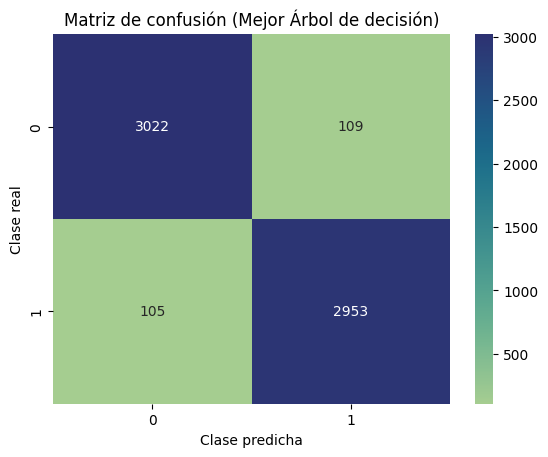

In [ ]:
plot_results(best_dt, X_train, y_train, X_test, y_test, 'Mejor Árbol de decisión')

Características más importantes para el arbol

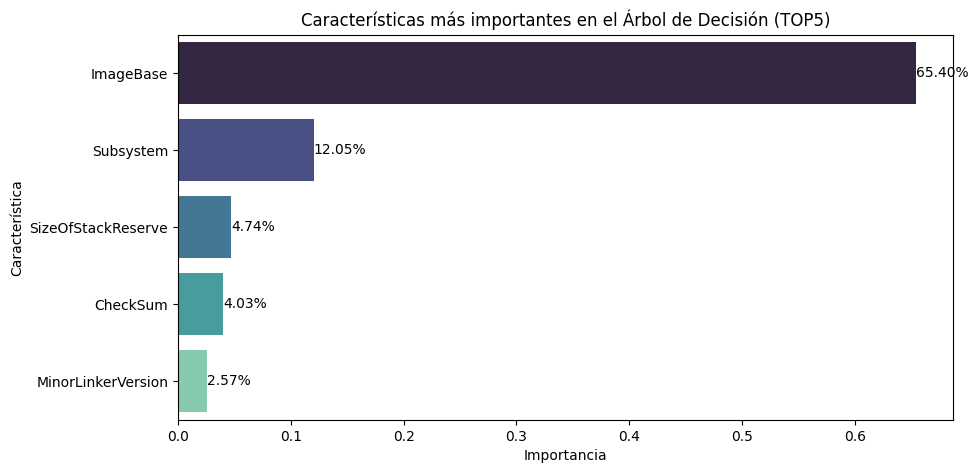

In [ ]:
importance = best_dt.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

#nos quedamos las 5 primeras por orden de importancia
top_5_importance = dict(list(sorted_importance.items())[:5])

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list(top_5_importance.values()), y=list(top_5_importance.keys()), palette='mako')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Características más importantes en el Árbol de Decisión (TOP5)')

# etiquetas de porcentaje
total = sum(importance)
for i, (key, value) in enumerate(top_5_importance.items()):
    percentage = value / total * 100
    ax.text(value, i, f"{percentage:.2f}%", ha='left', va='center')

plt.show()


Por último, visualizamos la estructura del árbol

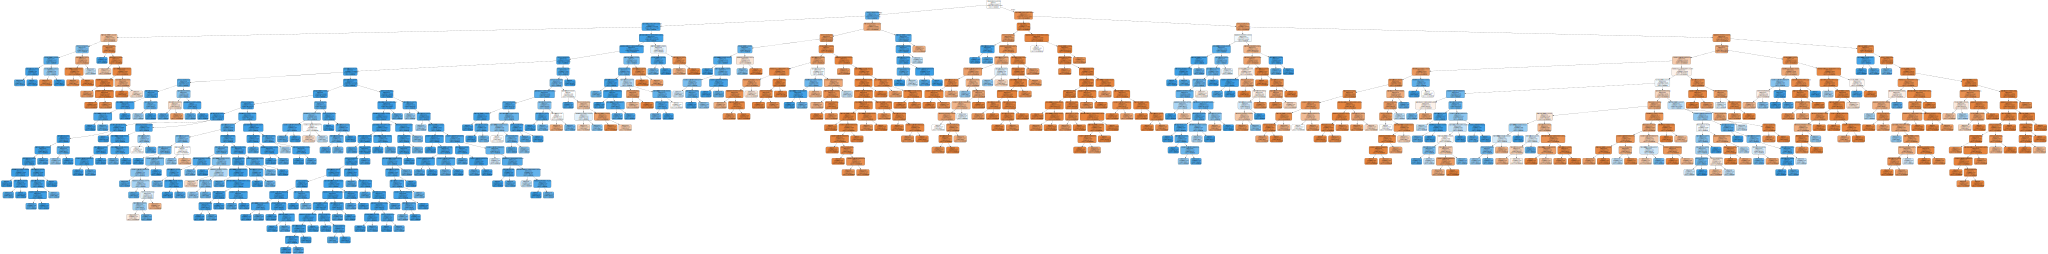

In [ ]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(best_dt, out_file=None, feature_names=X.columns,
                                class_names=['No Malware', 'Malware'], filled=True, rounded=True,
                                special_characters=True)

# dibujamos el arbol y lo exportamos en formato png
graph = graphviz.Source(dot_data)
graph


In [ ]:
#exportamos el arbol como png
graph.format = 'png'
graph.render('/content/gdrive/MyDrive/tfm_exports/arbol.png', view=False)

'/content/gdrive/MyDrive/tfm_exports/arbol.png.png'